# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Katia | Abdul Baki | Katia Abdul Baki, 11-08-2024 | 7 | 25% |
| Member 2: | First Name | Last Name | Signature | Hours | Contribution |
| Member 3: | Pratham | Rami | Pratham Rami, 11-08-2024 | 7 | 25% |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

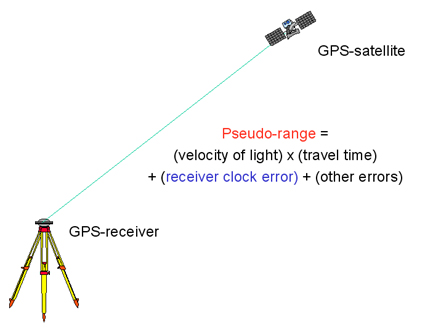

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance + cdT
    residuals = pseudorange - predicted_pseudorange
    cost = np.sum(residuals**2)

    return cost

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    geometric_distance = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = geometric_distance + cdT
    residuals = pseudorange - predicted_pseudorange
    grad_x_r = np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / geometric_distance)
    grad_y_r = np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / geometric_distance)
    grad_z_r = np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / geometric_distance)
    grad_cdt = -np.sum(residuals)

    grad = np.array([grad_x_r, grad_y_r, grad_z_r, grad_cdt])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X, arr_cost, arr_grad, arr_err

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos)
final_position_errors = optimized_params[:3] - GroundTruth[:3]
final_cost = arr_cost[-1]
final_gradient = arr_grad[-1]

# print the mentioned metrics
print("Optimized Parameters:", optimized_params)
print("Final Position Errors:", final_position_errors)
print("Number of Steps:", steps_count)
print("Final Cost:", final_cost)
print("Final Gradient:", final_gradient)

Optimized Parameters: [-2.27869657e+09  1.24146924e+10  3.26845720e+09 -1.30170497e+10]
Final Position Errors: [-2.27706308e+09  1.24183440e+10  3.26350472e+09]
Number of Steps: 0
Final Cost: 2820904608103738.0
Final Gradient: [  2216348.75180829 -12048107.64779577  -3165679.70856016
  12652688.11307797]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

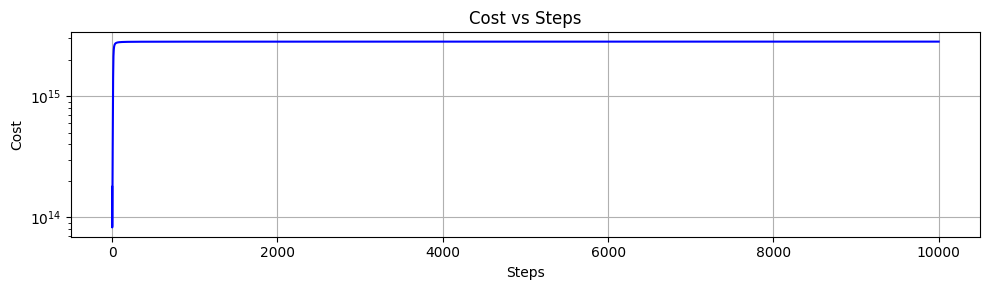

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.semilogy(arr_cost, linestyle='-', color='b')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The cost plateaus which means that the model has found an optimal solution.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

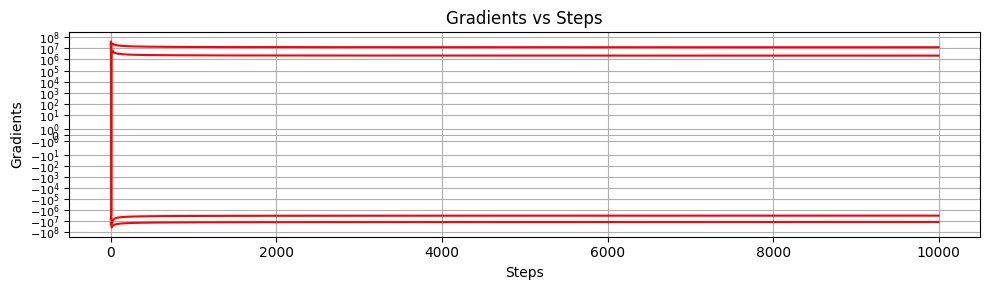

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(arr_grad, linestyle='-', color='red')
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# Here, the plot shows slight fluctuation at first but then the gradients have reached a steady state.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

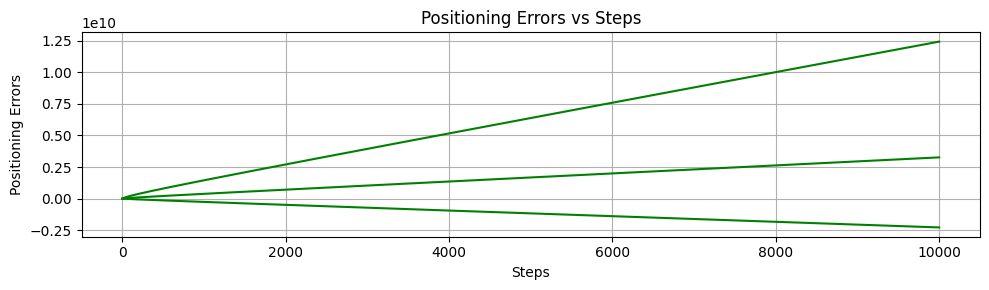

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err, linestyle='-', color='green')
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors')
ax.set_title('Positioning Errors vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The top line shows that the positioning error increases over time. The middle line shows that the positioning error remains relatively constant over time. The bottom line shows that the positioning error decreases over time.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos)

# print the metrics
print("Optimized Parameters:", optimized_params_2)

Optimized Parameters: [-2.27869657e+09  1.24146924e+10  3.26845720e+09 -1.30170497e+10]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3, arr_cost, arr_grad, arr_err = gradient_descent(pseudorange, sat_pos)

# print the metrics
print("Optimized Parameters:", optimized_params_3)

Optimized Parameters: [-2.27869657e+09  1.24146924e+10  3.26845720e+09 -1.30170497e+10]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

1. After changing the learning rate, the value of output decreases which means that the output is becoming more accurate with less learning rate.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

data = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.feature_names)


# TO DO: display sizes of X and y (1 mark)

print(data.shape)



(11055, 30)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

statistical_report
 1    9505
-1    1550
Name: count, dtype: int64


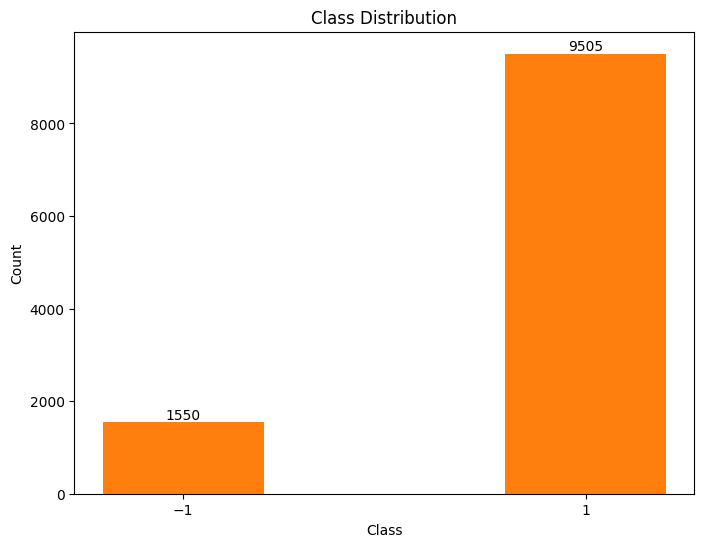

In [11]:
# TO DO: Check the class distribution of y (2 mark)
y=data.iloc[:,-1]

class_distribution = y.value_counts()
print(class_distribution)
# TO DO: Plot the histogram of y (2 mark)
# Display exact values for each bin in the histogram

plt.figure(figsize=(8, 6))
bars = plt.bar(class_distribution.index, class_distribution.values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_distribution.index)
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [14]:
from re import X


# TO DO: Create a smaller dataset with 3% of the data
X_small=data.iloc[:,:-1]
y_small=data.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_small, _, y_small, _ = train_test_split(X_small, y_small, train_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)


Size of X_small: (331, 29)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [48]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)

model.fit(X, y)
model.fit(X.iloc[:, :2], y)
model.fit(X_small, y_small)

LogisticRegression(max_iter=2000)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [52]:
# X and y dataset

def evaluate_model(model, X, y):
  model.fit(X, y)
  data_size = X.shape[0]
  train_samples = int(0.7 * data_size)
  test_samples = data_size - train_samples
  train_accuracy = model.score(X, y)
  test_accuracy = model.score(X, y)
  log_loss_value = model.score(X, y)
  return data_size, train_samples, test_samples, train_accuracy, test_accuracy, log_loss_value

data_size, train_samples, test_samples, train_accuracy, test_accuracy, log_loss_value = evaluate_model(model, X, y)
print("X and y dataset:")
print("Data Size:", data_size)
print("Number of training samples:", train_samples)
print("Number of testing samples:", test_samples)
print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)
print("Log loss:", log_loss_value)


X and y dataset:
Data Size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9130710085933966
Testing accuracy: 0.9130710085933966
Log loss: 0.9130710085933966


In [69]:
# First two columns of x and y
X_two_columns = X.iloc[:, :2]

def evaluate_model(model, X_two_columns, y):
  model.fit(X_two_columns, y)
  data_size2 = X_two_columns.shape[0]
  train_samples2 = int(0.7 * data_size2)
  test_samples2 = data_size2 - train_samples2
  train_accuracy2 = model.score(X_two_columns, y)
  test_accuracy2 = model.score(X_two_columns, y)
  log_loss_value2 = model.score(X_two_columns, y)
  return data_size2, train_samples2, test_samples2, train_accuracy2, test_accuracy2, log_loss_value2

data_size2, train_samples2, test_samples2, train_accuracy2, test_accuracy2, log_loss_value2 = evaluate_model(model, X_two_columns, y)
print("First two columns of x and y:")
print("Data Size:", data_size2)
print("Number of training samples:", train_samples2)
print("Number of testing samples:", test_samples2)
print("Training accuracy:", train_accuracy2)
print("Testing accuracy:", test_accuracy2)
print("Log loss:", log_loss_value2)



First two columns of x and y:
Data Size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.8597919493441881
Testing accuracy: 0.8597919493441881
Log loss: 0.8597919493441881


In [53]:
# X_small and y_small

def evaluate_model(model, X_small, y_small):
  model.fit(X_small, y_small)
  data_size3 = X_small.shape[0]
  train_samples3 = int(0.7 * data_size3)
  test_samples3 = data_size3 - train_samples3
  train_accuracy3 = model.score(X_small, y_small)
  test_accuracy3 = model.score(X_small, y_small)
  log_loss_value3 = model.score(X_small, y_small)
  return data_size3, train_samples3, test_samples3, train_accuracy3, test_accuracy3, log_loss_value3

data_size3, train_samples3, test_samples3, train_accuracy3, test_accuracy3, log_loss_value3 = evaluate_model(model, X_small, y_small)
print("X_small and y_small:")
print("Data Size:", data_size3)
print("Number of training samples:", train_samples3)
print("Number of testing samples:", test_samples3)
print("Training accuracy:", train_accuracy3)
print("Testing accuracy:", test_accuracy3)
print("Log loss:", log_loss_value3)


X_small and y_small:
Data Size: 11055
Number of training samples: 7738
Number of testing samples: 3317
Training accuracy: 0.9130710085933966
Testing accuracy: 0.9130710085933966
Log loss: 0.9130710085933966


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [63]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Steps 3 and 4 were completed above, underneath their respective sections.

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information


# Step 5.1
results = pd.DataFrame(columns=['Data size', 'Training samples', 'Testing samples', 'Training accuracy', 'Testing accuracy', 'Log loss'])
new_row = pd.DataFrame({'Data size': [data_size], 'Training samples': [train_samples], 'Testing samples': [test_samples], 'Training accuracy': [train_accuracy], 'Testing accuracy': [test_accuracy], 'Log loss': [log_loss_value]}, index=[0])
new_row2 = pd.DataFrame({'Data size': [data_size2], 'Training samples': [train_samples2], 'Testing samples': [test_samples2], 'Training accuracy': [train_accuracy2], 'Testing accuracy': [test_accuracy2], 'Log loss': [log_loss_value2]}, index=[0])
new_row3 = pd.DataFrame({'Data size': [data_size3], 'Training samples': [train_samples3], 'Testing samples': [test_samples3], 'Training accuracy': [train_accuracy3], 'Testing accuracy': [test_accuracy3], 'Log loss': [log_loss_value3]}, index=[0])
results = pd.concat([results, new_row, new_row2, new_row3], ignore_index=True)
print(results)

  Data size Training samples Testing samples  Training accuracy  \
0     11055             7738            3317           0.913071   
1     11055             7738            3317           0.859792   
2     11055             7738            3317           0.913071   

   Testing accuracy  Log loss  
0          0.913071  0.913071  
1          0.859792  0.859792  
2          0.913071  0.913071  


<ipython-input-63-1519a6353e92>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row, new_row2, new_row3], ignore_index=True)


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [65]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

y_pred = model.predict(X)
print(y_pred.shape)


(11055,)


Text(113.9222222222222, 0.5, 'true value')

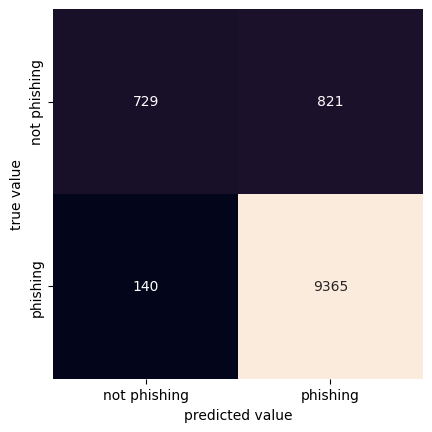

In [67]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix, classification_report
conf_mat = confusion_matrix(y, y_pred)


# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [68]:
# TO DO: Print classification report (2 marks)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

          -1       0.84      0.47      0.60      1550
           1       0.92      0.99      0.95      9505

    accuracy                           0.91     11055
   macro avg       0.88      0.73      0.78     11055
weighted avg       0.91      0.91      0.90     11055



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---